# 3層ANNによる非線形歪補償
最も基本的な、入力層・中間層・出力層からなる3層ANNによる補償

In [1]:
#import
import sys
import os
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

sys.path.append('../')
from pyopt.util import save_pickle, load_pickle

# 1. Preprocessing

## 1.1 データの整形

In [2]:
def data_shaping(input_signal, signal, max_tap, tap):
    """
    input_signal: 伝送前の信号
    signal: 伝送後の信号
    max_tap: 最大の同時入力シンボル数
    tap: 同時入力シンボル数
    
    signal = [x_0, x_1, ... , x_(n-1)]
      |
      |
      v
    x = [[x_0, x_1, ... , x_tap-1],
            [x_1, x_2, ..., x_tap],
                   .
                   .
                   .
            [x_(n-tap), x_(n-tap+1), ..., x(n-1)]]
      |
      |
      v
    x = [[i_0, q_0, i_1, q_1, ... , i_(tap-1), q_(tap-1)],
            [i_1, q_1, i_2, q_2, ... , i_tap, q_tap],
                   .
                   .
                   .
            [i_(n-tap), q_(n-tap), i_(n-tap+1), q_(n-tap+1), ..., i_(n-1), q_(n-1)]] (batch, input_dim) input_dim = tap * 2
    
    y  (batch, output_dim) output_dim = 2
    """
    
    x = np.zeros((len(input_signal) - (max_tap - 1), tap * 2), dtype=float)
    y = np.zeros((len(input_signal) - (max_tap - 1), 2), dtype=float)
    for i, j in enumerate(np.arange(max_tap // 2, len(input_signal) - max_tap // 2)):
        x[i, 0::2] = signal[j - tap // 2: j + tap // 2 + 1].real
        x[i, 1::2] = signal[j - tap // 2: j + tap // 2 + 1].imag
        y[i, 0] = input_signal[j].real
        y[i, 1] = input_signal[j].imag
    return x, y

In [3]:
#動作確認
tap = 29
max_tap = 51

df_dir = '../data/input/prbs.csv'
df = pd.read_csv(df_dir, index_col=0)  # dataframe読み込み
condition = (df['N']==13) & (df['itr']==1) & (df['form']=='RZ16QAM') & (df['n']==32) & (df['equalize']==False) & (df['baudrate']==28) & (df['PdBm']==1)
sgnl = load_pickle(df[condition].iloc[0]['data_path'])  # dataframeから条件と合う行を取得し,pickleの保存先(data_path)にアクセス
lc = sgnl.linear_compensation(500, sgnl.signal['x_500'])
x, y = data_shaping(sgnl.signal['x_0'][16::32], lc[16::32], max_tap, tap)  # ANNに入力できるようにデータを整形

print('x size: ', x.shape)
print('y size: ', y.shape)

x size:  (1998, 58)
y size:  (1998, 2)


Text(0.5, 1.0, 'constellation L=500km 100%linear comp.')

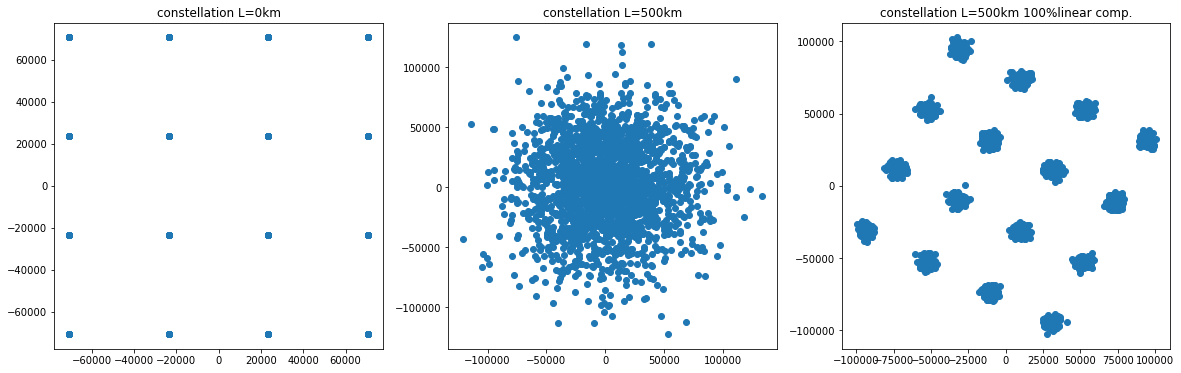

In [4]:
fig = plt.figure(figsize=(20, 6))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.plot(sgnl.signal['x_0'][16::32].real, sgnl.signal['x_0'][16::32].imag, 'o')
ax1.set_title('constellation L=0km')

ax2.plot(sgnl.signal['x_500'][16::32].real, sgnl.signal['x_500'][16::32].imag, 'o')
ax2.set_title('constellation L=500km')

ax3.plot(lc[16::32].real, lc[16::32].imag, 'o')
ax3.set_title('constellation L=500km 100%linear comp.')

## 1.2 平均,標準偏差の計算

In [5]:
mean = np.mean(x)
std = np.std(x)

print('mean: ', mean)
print('std: ', std)

mean:  1153.2726078905946
std:  52094.955682540436


# 2. Dataset定義

In [6]:
class Dataset(data.Dataset):
    def __init__(self, x, y, mean, std):
        self.x, self.y, self.mean, self.std = x, y, mean, std
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        
        x = (x - self.mean) / self.std
        y = (y - self.mean) / self.std
        return torch.Tensor(x), torch.Tensor(y)

In [7]:
#動作確認
train_dataset = Dataset(x=x, y=y, mean=mean, std=std)

index = 0
x_normalized, y_normalized = train_dataset.__getitem__(index)
x_array = x_normalized.detach().numpy()

print('mean: ', np.mean(x_array))
print('std: ', np.std(x_array))
print(x_normalized)
print(y_normalized)

mean:  -0.07779463
std:  0.9611322
tensor([ 0.9683, -1.0473, -0.6392,  1.8304, -0.6096,  1.8069,  0.6018,  0.2449,
         0.1362,  1.3867,  0.5366,  0.2621, -1.5248,  0.2728, -1.4926,  0.2234,
         1.3090, -0.1897,  0.6868,  0.1920,  0.2285, -0.6527,  0.1815, -0.6933,
        -1.4329,  0.1159, -0.9792,  1.0169, -1.0399,  1.0081,  0.5974, -1.7705,
        -0.2983,  0.5603, -0.9364,  0.9230, -0.2438, -1.4622, -0.2386,  0.5812,
        -1.0157,  0.9883, -1.7897, -0.5673, -1.0621,  0.9487, -1.3093,  0.2718,
         1.8213,  0.6160,  0.9406, -0.9756, -1.8251, -0.6797, -0.6066, -0.2726,
         0.1639, -0.5788])
tensor([-1.3750,  0.4288])


In [8]:
batch_size = 100

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

dataloaders_dict = {'train': train_dataloader}

# 3. Model定義

In [56]:
class ANN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_neuron):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_neuron)
        self.fc2 = nn.Linear(hidden_neuron, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
#動作確認
hidden_neuron = 300
device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron).to(device)
for x, y in train_dataloader:
    output = model(x)
    print(output[:6])
    break

Device available now: cpu
tensor([[ 0.0314, -0.1387],
        [-0.1714, -0.2439],
        [ 0.3780,  0.2766],
        [ 0.1245,  0.0541],
        [-0.1241,  0.0703],
        [ 0.1848,  0.1749]], grad_fn=<SliceBackward>)


# 4. train定義

In [41]:
def evm_score(y_pred, y_true):
    if y_true.ndim == 2:
        y_true = y_true[:, 0] + 1j * y_true[:, 1]
        y_pred = y_pred[:, 0] + 1j * y_pred[:, 1]
    tmp = 0
    for i in range(len(y_pred)):
        tmp += abs(y_pred[i] - y_true[i]) ** 2 / abs(y_true[i]) ** 2
    evm = torch.sqrt(tmp / len(y_pred))
    return evm

In [42]:
def evm_score2(y_pred, y_true):
    tmp = 0
    for i in range(len(y_pred)):
        tmp += ((y_pred[i][0] - y_true[i][0]) ** 2 + (y_pred[i][1] - y_true[i][1]) ** 2) / (y_true[i][0] ** 2 + y_true[i][1] ** 2)
    evm = torch.sqrt(tmp / len(y_pred))
    return evm

In [29]:
y_true = np.array([[1/np.sqrt(2), 1/np.sqrt(2)], [-1/np.sqrt(2), 1/np.sqrt(2)]])
y_pred = np.array([[0.7, 0.5], [-0.6, 0.3]])
print(evm_score(y_true, y_pred))
print(evm_score2(y_true, y_pred))

33.17766711332341
33.17766711332341


In [50]:
def train_model(device, model, dataloaders_dict, criterion, optimizer, epochs, epochs_section=None):
    for epoch in range(epochs):
        if epochs_section is not None:
            epoch += epochs_section[0]
            end_epoch = epochs_section[1]
        else:
            end_epoch = epochs
        
        start_time = time.time()
        
        for phase in dataloaders_dict.keys():
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_evms = 0.0
            
            for x, y in dataloaders_dict[phase]:
                x = x.to(device)
                y = y.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                    epoch_loss += loss.item() * x.size(0)
                    epoch_evms += (evm_score2(outputs, y)) ** 2 * x.size(0)
            
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_evm = torch.sqrt(epoch_evms / len(dataloaders_dict[phase].dataset)) * 100
            
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
            print('{} | Epoch: {}/{} | {} Loss: {:.4} | EVM: {:.4}'.format(duration, epoch + 1, end_epoch, phase, epoch_loss, epoch_evm))
    return model

In [51]:
#動作確認
epochs = 5
lr = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs);

0:00:00 | Epoch: 1/5 | train Loss: 0.001862 | EVM: 4.559
0:00:03 | Epoch: 1/5 | val Loss: 0.00124 | EVM: 4.075
0:00:00 | Epoch: 2/5 | train Loss: 0.0004141 | EVM: 2.146
0:00:03 | Epoch: 2/5 | val Loss: 0.0009153 | EVM: 3.632
0:00:00 | Epoch: 3/5 | train Loss: 0.0002319 | EVM: 1.598
0:00:03 | Epoch: 3/5 | val Loss: 0.0009111 | EVM: 3.637
0:00:00 | Epoch: 4/5 | train Loss: 0.0002019 | EVM: 1.49
0:00:02 | Epoch: 4/5 | val Loss: 0.0008698 | EVM: 3.59
0:00:00 | Epoch: 5/5 | train Loss: 0.0001782 | EVM: 1.408
0:00:03 | Epoch: 5/5 | val Loss: 0.0008933 | EVM: 3.625


# 5. 実行

In [54]:
#結果を保存しない
tap = 1
max_tap = 501
batch_size = 100
hidden_neuron = 300
epochs = 500
lr = 0.001

device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else 
print('Device available now:', device)

df_dir = '../data/input/'
df0 = pd.read_csv(df_dir+'prbs.csv', index_col=0)

condition0 = (df0['N']==13) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl0 = load_pickle(df0[condition0].iloc[0]['data_path'])
lc0 = sgnl0.linear_compensation(2500, sgnl0.signal['x_2500'])
x0, y0 = data_shaping(sgnl0.signal['x_0'][16::32], lc0[16::32], max_tap, tap)

condition1 = (df0['N']==17) & (df0['itr']==1) & (df0['form']=='RZ16QAM') & (df0['n']==32) & (df0['equalize']==False) & (df0['baudrate']==28) & (df0['PdBm']==1)
sgnl1 = load_pickle(df0[condition1].iloc[0]['data_path'])
lc1 = sgnl1.linear_compensation(2500, sgnl1.signal['x_2500'])
x1, y1 = data_shaping(sgnl1.signal['x_0'][16::32], lc1[16::32], max_tap, tap)

mean = np.mean(x0)
std = np.std(x0)

train_dataset = Dataset(x=x0, y=y0, mean=mean, std=std)
val_dataset = Dataset(x=x1, y=y1, mean=mean, std=std)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=hidden_neuron).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(params=model.parameters(), lr=lr)

model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=epochs)

Device available now: cpu
0:00:00 | Epoch: 1/500 | train Loss: 0.2682 | EVM: 51.78
0:00:04 | Epoch: 1/500 | val Loss: 0.06846 | EVM: 34.16
0:00:00 | Epoch: 2/500 | train Loss: 0.03289 | EVM: 23.67
0:00:04 | Epoch: 2/500 | val Loss: 0.02558 | EVM: 19.32
0:00:00 | Epoch: 3/500 | train Loss: 0.01691 | EVM: 17.7
0:00:04 | Epoch: 3/500 | val Loss: 0.01804 | EVM: 18.96
0:00:00 | Epoch: 4/500 | train Loss: 0.01348 | EVM: 16.5
0:00:04 | Epoch: 4/500 | val Loss: 0.01509 | EVM: 17.3
0:00:00 | Epoch: 5/500 | train Loss: 0.01248 | EVM: 16.02
0:00:04 | Epoch: 5/500 | val Loss: 0.01562 | EVM: 17.62
0:00:00 | Epoch: 6/500 | train Loss: 0.01225 | EVM: 15.79
0:00:04 | Epoch: 6/500 | val Loss: 0.01464 | EVM: 17.14
0:00:00 | Epoch: 7/500 | train Loss: 0.01194 | EVM: 15.58
0:00:04 | Epoch: 7/500 | val Loss: 0.01436 | EVM: 16.89
0:00:00 | Epoch: 8/500 | train Loss: 0.01177 | EVM: 15.54
0:00:04 | Epoch: 8/500 | val Loss: 0.01449 | EVM: 17.0
0:00:00 | Epoch: 9/500 | train Loss: 0.01177 | EVM: 15.57
0:00:04 |

0:00:00 | Epoch: 71/500 | train Loss: 0.002172 | EVM: 7.454
0:00:04 | Epoch: 71/500 | val Loss: 0.003543 | EVM: 9.018
0:00:00 | Epoch: 72/500 | train Loss: 0.002178 | EVM: 7.349
0:00:04 | Epoch: 72/500 | val Loss: 0.003661 | EVM: 9.168
0:00:00 | Epoch: 73/500 | train Loss: 0.001983 | EVM: 7.145
0:00:04 | Epoch: 73/500 | val Loss: 0.003433 | EVM: 8.892
0:00:00 | Epoch: 74/500 | train Loss: 0.001969 | EVM: 7.064
0:00:04 | Epoch: 74/500 | val Loss: 0.003336 | EVM: 8.7
0:00:00 | Epoch: 75/500 | train Loss: 0.001923 | EVM: 6.946
0:00:04 | Epoch: 75/500 | val Loss: 0.003615 | EVM: 8.919
0:00:00 | Epoch: 76/500 | train Loss: 0.001898 | EVM: 6.84
0:00:04 | Epoch: 76/500 | val Loss: 0.003005 | EVM: 8.355
0:00:00 | Epoch: 77/500 | train Loss: 0.001795 | EVM: 6.755
0:00:04 | Epoch: 77/500 | val Loss: 0.003196 | EVM: 8.403
0:00:00 | Epoch: 78/500 | train Loss: 0.001844 | EVM: 6.737
0:00:04 | Epoch: 78/500 | val Loss: 0.002812 | EVM: 8.093
0:00:00 | Epoch: 79/500 | train Loss: 0.001631 | EVM: 6.406

0:00:00 | Epoch: 140/500 | train Loss: 0.0003751 | EVM: 2.828
0:00:04 | Epoch: 140/500 | val Loss: 0.001175 | EVM: 4.711
0:00:00 | Epoch: 141/500 | train Loss: 0.0003624 | EVM: 2.763
0:00:04 | Epoch: 141/500 | val Loss: 0.001131 | EVM: 4.647
0:00:00 | Epoch: 142/500 | train Loss: 0.0003068 | EVM: 2.667
0:00:04 | Epoch: 142/500 | val Loss: 0.001075 | EVM: 4.538
0:00:00 | Epoch: 143/500 | train Loss: 0.0002817 | EVM: 2.539
0:00:04 | Epoch: 143/500 | val Loss: 0.001214 | EVM: 4.753
0:00:00 | Epoch: 144/500 | train Loss: 0.0003158 | EVM: 2.677
0:00:04 | Epoch: 144/500 | val Loss: 0.001139 | EVM: 4.574
0:00:00 | Epoch: 145/500 | train Loss: 0.0002924 | EVM: 2.594
0:00:04 | Epoch: 145/500 | val Loss: 0.001064 | EVM: 4.492
0:00:00 | Epoch: 146/500 | train Loss: 0.0002928 | EVM: 2.532
0:00:04 | Epoch: 146/500 | val Loss: 0.001372 | EVM: 4.987
0:00:00 | Epoch: 147/500 | train Loss: 0.0003351 | EVM: 2.603
0:00:04 | Epoch: 147/500 | val Loss: 0.001171 | EVM: 4.616
0:00:00 | Epoch: 148/500 | train

0:00:00 | Epoch: 208/500 | train Loss: 0.0002073 | EVM: 2.013
0:00:04 | Epoch: 208/500 | val Loss: 0.0009776 | EVM: 4.114
0:00:00 | Epoch: 209/500 | train Loss: 0.0001665 | EVM: 1.857
0:00:04 | Epoch: 209/500 | val Loss: 0.001019 | EVM: 4.163
0:00:00 | Epoch: 210/500 | train Loss: 0.0001902 | EVM: 1.951
0:00:04 | Epoch: 210/500 | val Loss: 0.001014 | EVM: 4.093
0:00:00 | Epoch: 211/500 | train Loss: 0.0002263 | EVM: 2.016
0:00:04 | Epoch: 211/500 | val Loss: 0.001053 | EVM: 4.146
0:00:00 | Epoch: 212/500 | train Loss: 0.0002 | EVM: 1.956
0:00:04 | Epoch: 212/500 | val Loss: 0.001164 | EVM: 4.362
0:00:00 | Epoch: 213/500 | train Loss: 0.0002496 | EVM: 2.118
0:00:04 | Epoch: 213/500 | val Loss: 0.0009528 | EVM: 4.087
0:00:00 | Epoch: 214/500 | train Loss: 0.0002248 | EVM: 2.105
0:00:04 | Epoch: 214/500 | val Loss: 0.001095 | EVM: 4.441
0:00:00 | Epoch: 215/500 | train Loss: 0.0003155 | EVM: 2.359
0:00:04 | Epoch: 215/500 | val Loss: 0.001446 | EVM: 4.696
0:00:00 | Epoch: 216/500 | train 

0:00:00 | Epoch: 276/500 | train Loss: 0.0001419 | EVM: 1.708
0:00:04 | Epoch: 276/500 | val Loss: 0.0009906 | EVM: 4.101
0:00:00 | Epoch: 277/500 | train Loss: 0.000226 | EVM: 1.98
0:00:04 | Epoch: 277/500 | val Loss: 0.0009761 | EVM: 4.003
0:00:00 | Epoch: 278/500 | train Loss: 0.0003172 | EVM: 2.236
0:00:04 | Epoch: 278/500 | val Loss: 0.001164 | EVM: 4.195
0:00:00 | Epoch: 279/500 | train Loss: 0.0002246 | EVM: 1.89
0:00:04 | Epoch: 279/500 | val Loss: 0.0009738 | EVM: 3.941
0:00:00 | Epoch: 280/500 | train Loss: 0.0002715 | EVM: 2.061
0:00:04 | Epoch: 280/500 | val Loss: 0.001073 | EVM: 4.137
0:00:00 | Epoch: 281/500 | train Loss: 0.0001859 | EVM: 1.811
0:00:04 | Epoch: 281/500 | val Loss: 0.001021 | EVM: 4.08
0:00:00 | Epoch: 282/500 | train Loss: 0.0002846 | EVM: 2.232
0:00:04 | Epoch: 282/500 | val Loss: 0.001408 | EVM: 4.566
0:00:00 | Epoch: 283/500 | train Loss: 0.000606 | EVM: 3.014
0:00:04 | Epoch: 283/500 | val Loss: 0.001035 | EVM: 4.233
0:00:00 | Epoch: 284/500 | train L

0:00:04 | Epoch: 343/500 | val Loss: 0.0008494 | EVM: 3.743
0:00:00 | Epoch: 344/500 | train Loss: 8.701e-05 | EVM: 1.377
0:00:04 | Epoch: 344/500 | val Loss: 0.00101 | EVM: 4.144
0:00:00 | Epoch: 345/500 | train Loss: 0.0003177 | EVM: 2.282
0:00:04 | Epoch: 345/500 | val Loss: 0.001017 | EVM: 4.071
0:00:00 | Epoch: 346/500 | train Loss: 0.0001905 | EVM: 1.771
0:00:04 | Epoch: 346/500 | val Loss: 0.0009706 | EVM: 4.006
0:00:00 | Epoch: 347/500 | train Loss: 0.0001266 | EVM: 1.521
0:00:04 | Epoch: 347/500 | val Loss: 0.0009175 | EVM: 3.887
0:00:00 | Epoch: 348/500 | train Loss: 0.000143 | EVM: 1.527
0:00:04 | Epoch: 348/500 | val Loss: 0.0008441 | EVM: 3.731
0:00:00 | Epoch: 349/500 | train Loss: 0.0001023 | EVM: 1.345
0:00:04 | Epoch: 349/500 | val Loss: 0.0008284 | EVM: 3.736
0:00:00 | Epoch: 350/500 | train Loss: 0.0001204 | EVM: 1.461
0:00:04 | Epoch: 350/500 | val Loss: 0.0008959 | EVM: 3.812
0:00:00 | Epoch: 351/500 | train Loss: 0.0001044 | EVM: 1.407
0:00:04 | Epoch: 351/500 | v

0:00:00 | Epoch: 411/500 | train Loss: 0.0004788 | EVM: 2.415
0:00:04 | Epoch: 411/500 | val Loss: 0.001032 | EVM: 4.061
0:00:00 | Epoch: 412/500 | train Loss: 0.0002153 | EVM: 1.747
0:00:04 | Epoch: 412/500 | val Loss: 0.0009496 | EVM: 3.852
0:00:00 | Epoch: 413/500 | train Loss: 0.0001052 | EVM: 1.275
0:00:04 | Epoch: 413/500 | val Loss: 0.0008766 | EVM: 3.761
0:00:00 | Epoch: 414/500 | train Loss: 8.619e-05 | EVM: 1.235
0:00:04 | Epoch: 414/500 | val Loss: 0.0008032 | EVM: 3.69
0:00:00 | Epoch: 415/500 | train Loss: 5.835e-05 | EVM: 1.137
0:00:04 | Epoch: 415/500 | val Loss: 0.0008082 | EVM: 3.675
0:00:00 | Epoch: 416/500 | train Loss: 4.172e-05 | EVM: 0.9509
0:00:04 | Epoch: 416/500 | val Loss: 0.0008291 | EVM: 3.728
0:00:00 | Epoch: 417/500 | train Loss: 7.819e-05 | EVM: 1.231
0:00:04 | Epoch: 417/500 | val Loss: 0.0008085 | EVM: 3.678
0:00:00 | Epoch: 418/500 | train Loss: 5.481e-05 | EVM: 1.048
0:00:04 | Epoch: 418/500 | val Loss: 0.0008067 | EVM: 3.67
0:00:00 | Epoch: 419/500 |

0:00:04 | Epoch: 478/500 | val Loss: 0.0009745 | EVM: 3.885
0:00:00 | Epoch: 479/500 | train Loss: 0.0001528 | EVM: 1.379
0:00:04 | Epoch: 479/500 | val Loss: 0.0009151 | EVM: 3.842
0:00:00 | Epoch: 480/500 | train Loss: 8.364e-05 | EVM: 1.101
0:00:04 | Epoch: 480/500 | val Loss: 0.0008508 | EVM: 3.768
0:00:00 | Epoch: 481/500 | train Loss: 6.474e-05 | EVM: 1.06
0:00:04 | Epoch: 481/500 | val Loss: 0.0008217 | EVM: 3.694
0:00:00 | Epoch: 482/500 | train Loss: 4.851e-05 | EVM: 0.9588
0:00:04 | Epoch: 482/500 | val Loss: 0.0008335 | EVM: 3.716
0:00:00 | Epoch: 483/500 | train Loss: 3.769e-05 | EVM: 0.8215
0:00:04 | Epoch: 483/500 | val Loss: 0.0007913 | EVM: 3.651
0:00:00 | Epoch: 484/500 | train Loss: 3.133e-05 | EVM: 0.8158
0:00:04 | Epoch: 484/500 | val Loss: 0.0007832 | EVM: 3.628
0:00:00 | Epoch: 485/500 | train Loss: 2.518e-05 | EVM: 0.7409
0:00:04 | Epoch: 485/500 | val Loss: 0.0007839 | EVM: 3.633
0:00:00 | Epoch: 486/500 | train Loss: 4.2e-05 | EVM: 0.8605
0:00:04 | Epoch: 486/5

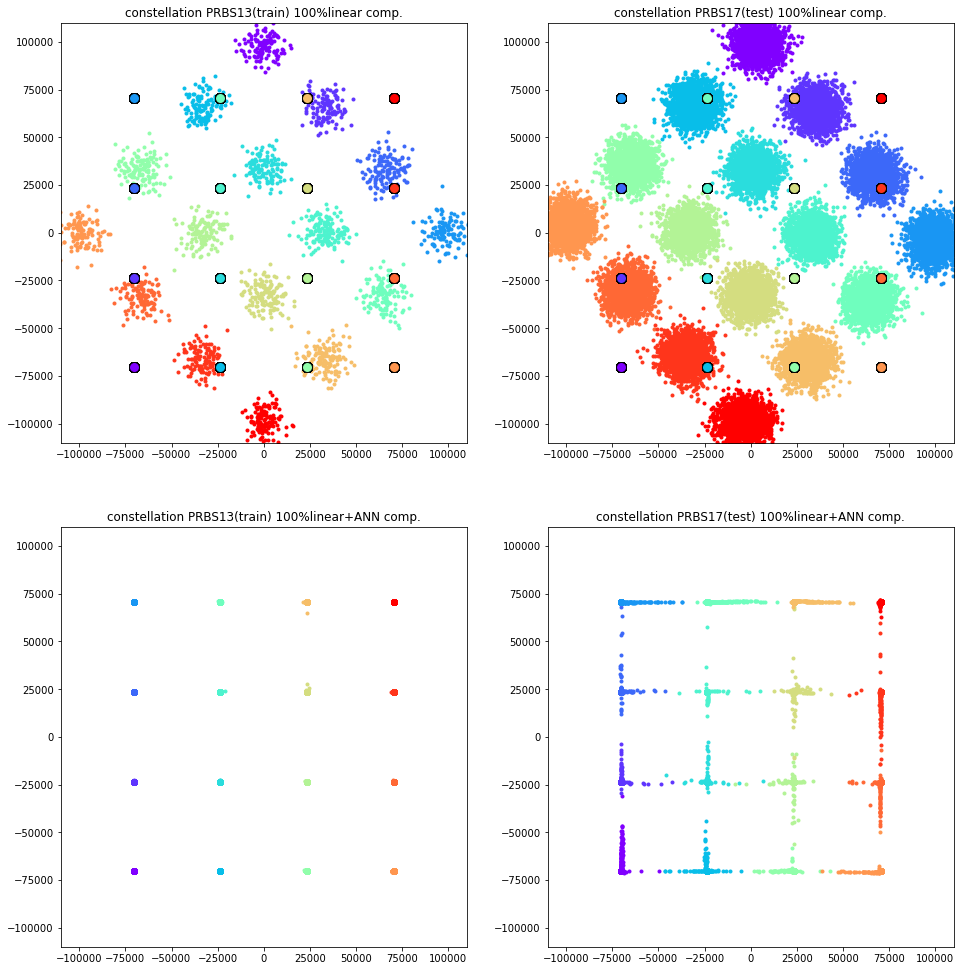

In [74]:
#可視化
annc0 = model(train_dataset[:][0]).detach().numpy()
annc0 = annc0 * std + mean
annc0 = annc0[:, 0] + annc0[:, 1] * 1j
y0 = train_dataset[:][1].detach().numpy()
y0 = y0 * std + mean
y0 = y0.astype(np.int32)
y0 = y0[:, 0] + y0[:, 1] * 1j
annc1 = model(val_dataset[:][0]).detach().numpy()
annc1 = annc1 * std + mean
annc1 = annc1[:, 0] + annc1[:, 1] * 1j
y1 = val_dataset[:][1].detach().numpy()
y1 = y1 * std + mean
y1 = y1.astype(np.int32)
y1 = y1[:, 0] + y1[:, 1] * 1j

lim = 110000
cm = plt.get_cmap('rainbow', 16)

seq0 = sgnl0.signal['x_0'][16::32]
seq1 = sgnl1.signal['x_0'][16::32]
symbol, inverse, counts = np.unique(seq0, return_inverse=True, return_counts=True)
symbol_int = symbol.real.astype(np.int32) + symbol.imag.astype(np.int32) * 1j

fig = plt.figure(figsize=(16, 17))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

for i in range(len(symbol)):
    ax1.plot(lc0[16::32][seq0 == symbol[i]].real, lc0[16::32][seq0 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax1.plot(seq0[seq0 == symbol[i]].real, seq0[seq0 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax1.set_title('constellation PRBS13(train) 100%linear comp.')
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax2.plot(lc1[16::32][seq1 == symbol[i]].real, lc1[16::32][seq1 == symbol[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]], label=str(counts[i]))
for i in range(len(symbol)):
    ax2.plot(seq1[seq1 == symbol[i]].real, seq1[seq1 == symbol[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]], markersize=10, markeredgewidth=1, markeredgecolor='black')
ax2.set_title('constellation PRBS17(test) 100%linear comp.')
ax2.set_xlim(-lim, lim)
ax2.set_ylim(-lim, lim)

for i in range(len(symbol)):
    ax3.plot(annc0[y0 == symbol_int[i]].real, annc0[y0 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax3.plot(y0[y0 == symbol_int[i]].real, y0[y0 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax3.set_title('constellation PRBS13(train) 100%linear+ANN comp.')
ax3.set_xlim(-lim, lim)
ax3.set_ylim(-lim, lim)


for i in range(len(symbol)):
    ax4.plot(annc1[y1 == symbol_int[i]].real, annc1[y1 == symbol_int[i]].imag, '.', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
for i in range(len(symbol)):
    ax4.plot(y1[y1 == symbol_int[i]].real, y1[y1 == symbol_int[i]].imag, 'o', color=[cm(i)[0], cm(i)[1], cm(i)[2]])
ax4.set_title('constellation PRBS17(test) 100%linear+ANN comp.')
ax4.set_xlim(-lim, lim)
ax4.set_ylim(-lim, lim);

In [ ]:
#結果と条件を../data/params/ANN.csvに保存する
tap = 1
max_tap = 501
batch_size = 100
neuron = 300
epochs = 100
lr = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

signal_type = 'image'

form = 'RZ16QAM'  # 変調方式
n = 32  # 1シンボルあたりのサンプリング数[/symbol]
equalize = False  # 各シンボル数を均等にするか
baudrate = 28  # ボーレート[GBaud]
PdBm = 1  # 平均入力光パワー[dBm]
Ledfa = 100  # EDFAスパン[km]
stepedfa = 30  # SSFMの繰り返し計算ステップ数
gamma = 1.4  # 非線形係数[/W/km]
D = 16  # 分散パラメータ[ps/nm/km]
Alpha = 0.16  # 伝送損失[dB/km]
NF = 4  # ASE雑音指数[dB]
Lmax = 500  # 伝送距離[km]
ase = True  # ASE雑音を考慮するか

if signal_type == 'prbs':
    N = 13  # PRBSの次数
    itr = 1  # PRBSの繰り返し回数
elif signal_type == 'random':
    seed = 1234  # 乱数シード
    bit_num = 10000  # ビット長を指定
elif signal_type == 'image':
    target_dir = 'train'
    step = 10  # =10 ---> (768, 1024) ---> (76, 102)
    image_number = [0, 1]
    ebtb = True  # 8B10Bを行うか

# prbs.csv or random.csv or image.csvをpandasで読み込む
t_df_dir = '../data/input/'
t_df = pd.read_csv(t_df_dir+signal_type+'.csv', index_col=0)

# if ANN.csv がある: pandasで読み込む if ANN.csvがない: 新しいDataFrameを作る
l_df_dir = '../data/params/ANN.csv'
if os.path.exists(l_df_dir):
    l_df = pd.read_csv(l_df_dir, index_col=0)
else:
    cols = ['tap', 'max_tap', 'batch_size', 'neuron', 'epochs', 'learning_rate', 'N', 'itr', 'seed', 'bit_num', 'target_dir', 'step', 'image_number', 'ebtb', 'form', 'n', 'equalize', 'baudrate', 'PdBm', 'Ledfa', 'stepedfa', 'gamma', 'D', 'Alpha', 'NF', 'Lmax', 'ase', 'params_path', 'train_samples']
    l_df = pd.DataFrame(index=[], columns=cols)
    l_df.to_csv(l_df_dir)

# 指定した学習条件と伝送条件
l_condition = 'tap=='+str(tap)+'&max_tap=='+str(max_tap)+'&batch_size=='+str(batch_size)+'&neuron=='+str(neuron)+'&learning_rate=='+str(lr)
t_condition = 'form=="'+str(form)+'"&n=='+str(n)+'&equalize=='+str(equalize)+'&baudrate=='+str(baudrate)+'&PdBm=='+str(PdBm)+'&Ledfa=='+str(Ledfa)+'&stepedfa=='+str(stepedfa)+'&\
                        gamma=='+str(gamma)+'&D=='+str(D)+'&Alpha=='+str(Alpha)+'&NF=='+str(NF)+'&ase=='+str(ase)
if signal_type == 'prbs':
    condition = 'N=='+str(N)+'&itr=='+str(itr)
    condition_list = [N, itr] + [None] * 6
elif signal_type == 'random':
    condition = 'seed=='+str(seed)+'&bit_num=='+str(bit_num)
    condition_list = [None] * 2 + [seed, bit_num] + [None] * 4
elif signal_type == 'image':
    condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+str(image_number[0])+'&ebtb=='+str(ebtb)
    condition_list = [None] * 4 + [target_dir, step, image_number, ebtb]

# prbs.csv or random.csv or image.csvにおいて、指定した伝送条件を見たす行を抜き出す
t_query = t_df.query(condition + '&' + t_condition)

# ANN.csvにおいて、指定した条件を満たす行だけqueryとして抜き出す
l_query = l_df.query(l_condition + '&' + condition + '&' + t_condition + '&Lmax=='+str(Lmax))

# 後で異なる値が代入されるもの以外をSeriesにしてしまう(epochs, params_path, train_samplesだけNone)
sr = pd.Series([tap, max_tap, batch_size, neuron, None, lr] + condition_list + [form, n, equalize, baudrate, PdBm, Ledfa, stepedfa, gamma, D, Alpha, NF, Lmax, ase, None, None], index=l_df.columns)
    
#if epochsを含む指定された条件を満たす結果がある: 何もしない
if len(l_query) > 0 and l_query['epochs'].max() >= epochs:
    print('指定された条件の学習結果はすでに存在します')
else:
    # if epochs以外の指定された条件を満たす結果がある: パラメータを読み込む if ない: 新しくモデルを作成する
    if len(l_query) > 0:
        index = l_query['epochs'].idxmax()
        trained_epochs = l_query['epochs'][index]
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
        model.load_state_dict(torch.load(l_query['params_path'][index]))
    else:
        trained_epochs = 0
        model = ANN(input_dim=tap*2, output_dim=2, hidden_neuron=neuron).to(device)
    
    # if prbs.csv or random.csv or image.csvに指定した伝送条件がない or Lmax以外は満たすがLmaxだけ指定した条件未満: 何もしない if ある: 続ける
    if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
        print('指定された伝送条件の信号が存在しません')
    else:
        # 伝送信号を学習データに整形する
        sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
        lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
        x_train, y_train = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
        
        if signal_type == 'image' and len(image_number) > 1:
            for i in range(1, len(image_number)):
                condition = 'target_dir=="'+str(target_dir)+'"&step=='+str(step)+'&image_number=='+str(image_number[i])+'&ebtb=='+str(ebtb)
                t_query = t_df.query(condition + '&' + t_condition)
                if len(t_query) == 0 or t_query.iloc[0]['Lmax'] < Lmax:
                    print('指定された伝送条件の信号が存在しません')
                    sys.exit()
                sgnl_train = load_pickle(t_query.iloc[0]['data_path'])
                lc_train = sgnl_train.linear_compensation(Lmax, sgnl_train.signal['x_' + str(Lmax)])
                x_train_tmp, y_train_tmp = data_shaping(sgnl_train.signal['x_0'][n//2::n], lc_train[n//2::n], max_tap, tap)
                x_train = np.concatenate([x_train, x_train_tmp])
                y_train = np.concatenate([y_train, y_train_tmp])
        
        train_samples = len(x_train)

        # 平均,標準偏差の計算
        mean = np.mean(x_train)
        std = np.std(x_train)

        # dataset, dataloaderの作成
        train_dataset = Dataset(x=x_train, y=y_train, mean=mean, std=std)
        train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        dataloaders_dict = {'train': train_dataloader}

        # 損失関数, オプティマイザの作成
        criterion = nn.MSELoss()
        optimizer = optim.Adam(params=model.parameters(), lr=lr)

        # モデルのトレーニング(50epochsずつ学習し、50epochsずつパラメータを保存する)
        for i in range((epochs - trained_epochs) // 50):
            model = train_model(device=device, model=model, dataloaders_dict=dataloaders_dict, criterion=criterion, optimizer=optimizer, epochs=50, epochs_section=[trained_epochs+i*50, epochs])

            # 学習済みパラメータを保存し、ANN.csvに保存先を記入する
            l_df = pd.read_csv(l_df_dir, index_col=0)
            params_path = '../data/params/ANN/params_' + str(len(l_df)).zfill(10) + '.pth'
            torch.save(model.state_dict(), params_path)
            sr[4] = trained_epochs + (i + 1) * 50
            sr[-2] = params_path
            sr[-1] = train_samples
            l_df = l_df.append(sr, ignore_index=True)
            l_df.to_csv(l_df_dir)

l_df